In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
from copy import deepcopy
import pylib.plotformat as pf

from matplotlib.colors import Normalize

 *******************************************************
 *                PyCrystalField 2.3.11               *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



# Toy model of a phonon crossing a CEF with $B_2^1$

In [2]:
ciffile = 'KCeO2.cif'
CeLig0, Ce = cef.importCIF(ciffile, 'Ce', NumIonNeighbors=2) # Generates point charge model
CeLig1, Ce = cef.importCIF(ciffile, 'Ce', NumIonNeighbors=2) # Generates point charge model 

LigandCharges = [-1.95,1]
# LigandCharges = [-1.73,0.5]
# LigandCharges = [-1.83,1.6]
symequivlabels = [0]*6 + [1]*6  ## This must be set by hand
Ce = CeLig0.PointChargeModel(symequiv = symequivlabels, LigandCharge=LigandCharges)
print(CeLig0.CentralIonPos)

unit cell: 3.65861 3.65861 18.58608 90.0 90.0 120.0
Importing atoms
   12 atoms added
.cif import complete.
Central ion: Ce3+ at [0.0, 0.0, 0.0]
    AAAH! There is a super-close atom. Removing it...
 Nearest ligand: O2-
 Next Nearest ligand: Ce3+
   Identified 6 O2- ligands.
   Identified 6 Ce3+ ligands.
   Found 3 fold axis about [0. 0. 2.]
   Found mirror plane: [1. 0. 0.]

  Axes for point charge model (in ABC space):
        X axis = [-0.5 -1.   0. ] 
        Y axis = [1. 0. 0.] 
        Z axis = [0. 0. 1.] 

   Creating a point charge model...
B_2 0  =  -5.45278484
B_2 1  =  -1.4e-07
B_2 2  =  1e-08
B_4 0  =  -0.23835377
B_4 1  =  -0.0
B_4 2  =  0.0
B_4 3  =  7.83773006
B_4 4  =  0.0
B_6 0  =  0.0
B_6 1  =  -0.0
B_6 2  =  -0.0
B_6 3  =  -0.0
B_6 4  =  0.0
B_6 5  =  -0.0
B_6 6  =  0.0
unit cell: 3.65861 3.65861 18.58608 90.0 90.0 120.0
Importing atoms
   12 atoms added
.cif import complete.
Central ion: Ce3+ at [0.0, 0.0, 0.0]
    AAAH! There is a super-close atom. Removing it...
 

In [3]:
print(Ce.B)
########### print eigenvectors
Ce.printEigenvectors() 
print(CeLig0.bonds)
print(CeLig0.LatticeTransformM)

[4.376256452144495, -1.3181324797635816e-07, -0.20062578294806882, 7.641786807254365]

 Eigenvalues 	 Eigenvectors
		-------------------------------------------------
0.00000 	|  [-0.484  0.     0.    -0.875 -0.    -0.   ]  |
0.00000 	|  [-0.     0.    -0.875 -0.     0.     0.484]  |
126.58166 	|  [-0.    -0.339  0.    -0.     0.941  0.   ]  |
126.58166 	|  [-0.     0.941  0.     0.     0.339 -0.   ]  |
171.08294 	|  [ 0.    -0.    -0.484 -0.     0.    -0.875]  |
171.08294 	|  [ 0.875  0.     0.    -0.484  0.     0.   ]  |
		-------------------------------------------------

[[ 2.11229947  0.          1.18845591]
 [-2.11229947  0.         -1.18845591]
 [ 1.05614973 -1.829305   -1.18845591]
 [ 1.05614973  1.829305   -1.18845591]
 [-1.05614973 -1.829305    1.18845591]
 [-1.05614973  1.829305    1.18845591]
 [ 3.1684492   1.829305    0.        ]
 [-3.1684492  -1.829305    0.        ]
 [ 3.1684492  -1.829305    0.        ]
 [-3.1684492   1.829305    0.        ]
 [ 0.         -3.65861     0

In [4]:
## Define phonon distortion operator: B20
ion, n,m = 'Ce3+', 2,1
ionJ = cef.Jion[ion][-1]
PhononOO = cef.StevensOp(ionJ,n,m) * 3.5

In [5]:
a_z = np.array([[1,0],[0,-1]])/2
a_mu = np.array([[0,1],[0,0]])
a_mu_dag = np.array([[0,0],[1,0]])
Hphon_small = np.dot(a_mu_dag, a_mu) 

III = np.identity(2)
H_cef = np.kron(Ce.H, III)
H_phon1 = np.kron(np.identity(len(Ce.H)),  Hphon_small)

####### Define CEF operators
CEFJx = np.kron(cef.Operator.Jx(Ce.J).O.real, III)
CEFJy = np.kron(cef.Operator.Jy(Ce.J).O.real, III)
CEFJz = np.kron(cef.Operator.Jz(Ce.J).O.real, III)

## Define phonon operators
PHOJp1 = np.kron(np.identity(len(Ce.H)), a_mu)
PHOJm1 = np.kron(np.identity(len(Ce.H)), a_mu_dag)

##################################
#
def CEFtransition(ket1, ket2):
    ax = np.dot(ket1, np.dot(CEFJx, ket2))**2
    ay = np.dot(ket1, np.dot(CEFJy, ket2))**2
    az = np.dot(ket1, np.dot(CEFJz, ket2))**2
    return np.real(ax + ay + az)

def PHOtransition(ket1, ket2):
    ap1 = np.dot(ket1, np.dot(PHOJp1, ket2))**2
    am1 = np.dot(ket1, np.dot(PHOJm1, ket2))**2
    return np.real(ap1 + am1)

#########################################################

## Calculate the eigenspectrum
PhononEE = np.linspace(0,200,401)
hbaromega = np.linspace(0,240,240*4+1)
Gwidth, Lwidth = 2, 0.5
CEF_neutronIntensity = np.zeros((len(PhononEE),len(hbaromega)))
Phonon_neutronIntensity = np.zeros((len(PhononEE),len(hbaromega)))

OO = PhononOO
for i in range(len(PhononEE)):
    H_int = np.kron(OO,  a_mu_dag + a_mu)
    H_phons = H_phon1*PhononEE[i]

    Ev1, Eve1 = np.linalg.eigh(H_cef + H_phons + H_int)
    Eval1 = Ev1 - np.min(Ev1)
    # if i == 0: Eval0 = deepcopy(Eval1)
    Evec1 = Eve1.T

    CEF_neutronIntensity_1 = np.zeros_like(hbaromega)
    PHO_neutronIntensity_1 = np.zeros_like(hbaromega)
    for j,ev in enumerate(Eval1):
        ev0 = Evec1[0]
        ev0b = Evec1[1]
        ev1 = Evec1[j]
        intensCF = CEFtransition(ev0, ev1) + CEFtransition(ev0b, ev1)
        intensPH = PHOtransition(ev0, ev1) + PHOtransition(ev0b, ev1)

        CEF_neutronIntensity_1 += Ce._voigt(hbaromega, ev, Gwidth, Lwidth)*intensCF
        PHO_neutronIntensity_1 += Ce._voigt(hbaromega, ev, Gwidth, Lwidth)*intensPH

    CEF_neutronIntensity[i] = CEF_neutronIntensity_1
    Phonon_neutronIntensity[i] = PHO_neutronIntensity_1

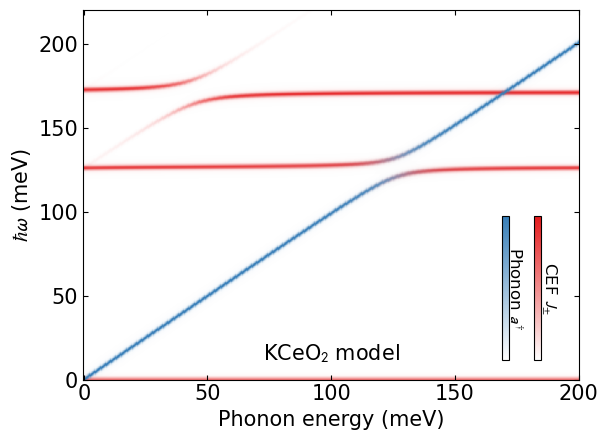

In [6]:
# Define custom colormap
from matplotlib.colors import ListedColormap

# totcol = 256
# cc00 = plt.get_cmap('Blues', totcol)
# cc01 = plt.get_cmap('Reds', totcol)
# newcolors0 = cc00(np.linspace(0, 1, totcol))
# newcolors1 = cc01(np.linspace(0, 1, totcol))
# for i in range(totcol):
#     white = np.array([1,1,1,0])
#     r = i/totcol
#     newcolors0[i, :] = r*newcolors0[i,:] + (1-r)*white
#     newcolors1[i, :] = r*newcolors1[i,:] + (1-r)*white
# MyCmp0 = ListedColormap(newcolors0)
# MyCmp1 = ListedColormap(newcolors1)

totcol = 256
newcolors0 = np.zeros((256,4))
newcolors1 = np.zeros((256,4)) 
for i in range(totcol):
    r = i/totcol
    white = np.array([1,1,1,r])
    newcolors0[i, :] = pf.cpal1[1]*white
    newcolors1[i, :] = pf.cpal1[0]*white
MyCmp0 = ListedColormap(newcolors0)
MyCmp1 = ListedColormap(newcolors1)

####### Plot

f,ax = plt.subplots()
plt.pcolormesh(PhononEE,hbaromega,CEF_neutronIntensity.T, rasterized=True,
               cmap=MyCmp1)
plt.pcolormesh(PhononEE,hbaromega,Phonon_neutronIntensity.T, rasterized=True,
               cmap=MyCmp0)
# plt.plot(PhononEE,PhononEE)

ax.set_ylim(0,220)
ax.set_xlabel('Phonon energy (meV)')
ax.set_ylabel('$\\hbar \\omega$ (meV)')

ax.text(0.5,0.04, 'KCeO$_2$ model', 
             va='bottom', ha='center', transform=ax.transAxes)

norm =Normalize(0,1)
cax1 = f.add_axes([0.83,0.15,0.01,0.3])
mappable = plt.cm.ScalarMappable(cmap=MyCmp1, norm = norm)
mappable.set_array([])
cbar = f.colorbar(mappable, cax = cax1, norm=norm, ticks=[])
cbar.set_label('CEF $J_{\\pm}$', 
               labelpad=13, fontsize=12, rotation=-90)

cax2 = f.add_axes([0.78,0.15,0.01,0.3])
mappable = plt.cm.ScalarMappable(cmap=MyCmp0, norm = norm)
mappable.set_array([])
cbar2 = f.colorbar(mappable, cax = cax2, norm=norm, ticks=[])
cbar2.set_label('Phonon $a^{\\dagger}$', 
               labelpad=12, fontsize=12, rotation=-90)

### Let's try this again, but with NaCeO2, which is NOT a tetragonal symmetry:

https://doi.org/10.1103/PhysRevB.103.024430

In [7]:
NaCeO2 = cef.CFLevels.Bdict('Ce3+',{'B20':0.9254, 'B40':0.3701, 'B44':1.3928})

NaCeO2.printEigenvectors()


 Eigenvalues 	 Eigenvectors
		-------------------------------------------------
0.00000 	|  [-0.316  0.     0.     0.     0.949  0.   ]  |
0.00000 	|  [ 0.     0.949  0.     0.     0.    -0.316]  |
117.90842 	|  [0. 0. 1. 0. 0. 0.]  |
117.90842 	|  [ 0.  0.  0. -1.  0.  0.]  |
124.79044 	|  [-0.949  0.     0.     0.    -0.316  0.   ]  |
124.79044 	|  [0.    0.316 0.    0.    0.    0.949]  |
		-------------------------------------------------



In [8]:

H_cef_NCO = np.kron(NaCeO2.H, III)

## Calculate the eigenspectrum
Gwidth, Lwidth = 2, 0.5
CEF_neutronIntensity_NCO = np.zeros((len(PhononEE),len(hbaromega)))
Phonon_neutronIntensity_NCO = np.zeros((len(PhononEE),len(hbaromega)))

OO = PhononOO
for i in range(len(PhononEE)):
    H_int = np.kron(OO,  a_mu_dag + a_mu)
    H_phons = H_phon1*PhononEE[i]

    Ev1, Eve1 = np.linalg.eigh(H_cef_NCO + H_phons + H_int)
    Eval1 = Ev1 - np.min(Ev1)
    # if i == 0: Eval0 = deepcopy(Eval1)
    Evec1 = Eve1.T

    CEF_neutronIntensity_1 = np.zeros_like(hbaromega)
    PHO_neutronIntensity_1 = np.zeros_like(hbaromega)
    for j,ev in enumerate(Eval1):
        ev0 = Evec1[0]
        ev0b = Evec1[1]
        ev1 = Evec1[j]
        intensCF = CEFtransition(ev0, ev1) + CEFtransition(ev0b, ev1)
        intensPH = PHOtransition(ev0, ev1) + PHOtransition(ev0b, ev1)

        CEF_neutronIntensity_1 += Ce._voigt(hbaromega, ev, Gwidth, Lwidth)*intensCF
        PHO_neutronIntensity_1 += Ce._voigt(hbaromega, ev, Gwidth, Lwidth)*intensPH

    CEF_neutronIntensity_NCO[i] = CEF_neutronIntensity_1
    Phonon_neutronIntensity_NCO[i] = PHO_neutronIntensity_1

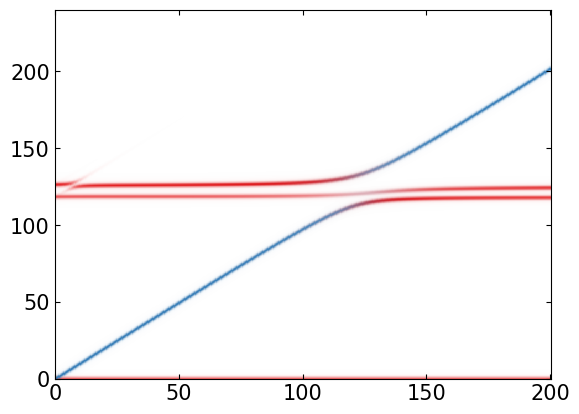

In [9]:
f,ax = plt.subplots()
plt.pcolormesh(PhononEE,hbaromega,CEF_neutronIntensity_NCO.T, rasterized=True,
               cmap=MyCmp1)
plt.pcolormesh(PhononEE,hbaromega,Phonon_neutronIntensity_NCO.T, rasterized=True,
               cmap=MyCmp0)
# plt.plot(PhononEE,PhononEE)



## Make a publication quality plot

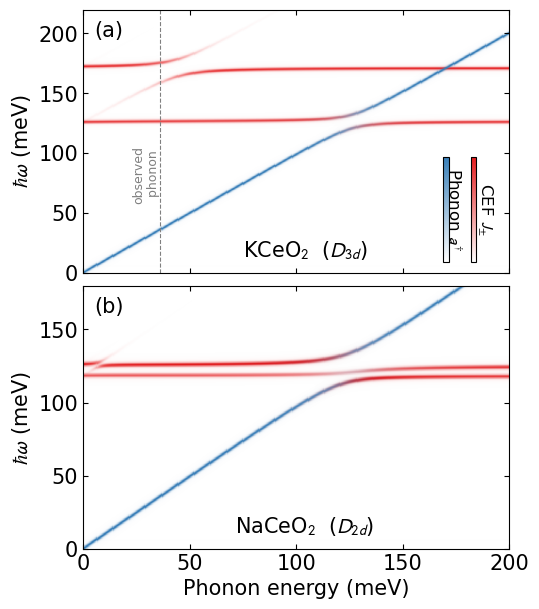

In [18]:
f,ax = plt.subplots(2,1,sharex=True, figsize=(5.5,7))

min_Ei = 20
ax[0].pcolormesh(PhononEE,hbaromega[min_Ei:],CEF_neutronIntensity[:,min_Ei:].T, 
                 rasterized=True, cmap=MyCmp1)
ax[0].pcolormesh(PhononEE,hbaromega,Phonon_neutronIntensity.T, 
                 rasterized=True,  cmap=MyCmp0)
ax[0].axvline(36.1, ls='--', color='grey', lw=0.8)
ax[0].text(36,60,'observed\nphonon ', rotation=90, fontsize=9, color='grey', ha='right')

ax[1].pcolormesh(PhononEE,hbaromega[min_Ei:],CEF_neutronIntensity_NCO[:,min_Ei:].T, 
                 rasterized=True, cmap=MyCmp1)
ax[1].pcolormesh(PhononEE,hbaromega,Phonon_neutronIntensity_NCO.T, 
                 rasterized=True, cmap=MyCmp0)

ax[-1].set_xlabel('Phonon energy (meV)')
labelz = ['KCeO$_2$  ($D_{3d}$)', 'NaCeO$_2$  ($D_{2d}$)']
for i,axx in enumerate(ax):
    axx.set_xlim(0,200)
    axx.set_ylabel('$\\hbar \\omega$ (meV)')
    axx.text(0.025,0.96, pf.parSubPlotLabel(i), 
             va='top', transform=axx.transAxes)
    axx.text(0.52,0.04, labelz[i], 
             va='bottom', ha='center', transform=axx.transAxes)
    
ax[0].set_ylim(0,220)
ax[1].set_ylim(0,180)

f.subplots_adjust(hspace=0.05)

##################################################

norm =Normalize(0,1)
cax1 = f.add_axes([0.83,0.52,0.01,0.15])
mappable = plt.cm.ScalarMappable(cmap=MyCmp1, norm = norm)
mappable.set_array([])
cbar = f.colorbar(mappable, cax = cax1, norm=norm, ticks=[])
cbar.set_label('CEF $J_{\\pm}$', 
               labelpad=13, fontsize=12, rotation=-90)

cax2 = f.add_axes([0.78,0.52,0.01,0.15])
mappable = plt.cm.ScalarMappable(cmap=MyCmp0, norm = norm)
mappable.set_array([])
cbar2 = f.colorbar(mappable, cax = cax2, norm=norm, ticks=[])
cbar2.set_label('Phonon $a^{\\dagger}$', 
               labelpad=11, fontsize=12, rotation=-90)

plt.savefig('writeup/ToyModelCoupling.pdf', bbox_inches='tight',
            pad_inches = 0.03, dpi=600)